In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [75]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [85]:
#clase para los individuos del problema de QAP

class QAP:
    def __init__(self, distancias, flujos):
        self.distancias = distancias
        self.flujos = flujos
        
    def evaluate(self, permutacion):
      n = len(permutacion)
      suma = 0
      for i in range(n):
          for j in range(n):
              suma += self.flujos[i, j] * self.distancias[permutacion[i]-1, permutacion[j]-1]
      return suma

In [79]:

#funcion de lectura de archivos
def leerArchivo(nombre):
    with open(nombre, 'r') as archivo:
        lines = archivo.readlines()

    # Leer el número de variables
    nInstalaciones = int(lines[0].strip())

    # Leer la matriz de flujos
    matrizF = []
    for i in range(nInstalaciones):
        matrizF.append(list(map(int, lines[2 + i].strip().split())))

    # Leer la matriz de distancias
    matrizD = []
    for i in range(nInstalaciones):
        matrizD.append(list(map(int, lines[3 + nInstalaciones + i].strip().split())))
    archivo.close()
    return nInstalaciones, matrizF, matrizD




In [110]:
def GA(QAP, population_size, mutation_rate, generations, crosstype="onepoint", elite_ratio=0.1):
    def generarPoblacionInicial(size):
        return [np.random.permutation(len(QAP.distancias)) for _ in range(size)]

    def evaluar(poblacion):
        return [QAP.evaluate(individual) for individual in poblacion]

    def SeleccionarPadres(poblacion, fitness):
        if not all(np.isfinite(f) for f in fitness):
            raise ValueError("Hay valores no finitos en fitness: {}".format(fitness))
        
        fitness_probs = [1 / f if f > 0 else 1e-10 for f in fitness]
                
        if not all(np.isfinite(p) for p in fitness_probs):
            raise ValueError("Hay valores no finitos en fitness_probs: {}".format(fitness_probs))

        sum_probs = sum(fitness_probs)
        if sum_probs == 0:
            raise ValueError("Suma de fitness_probs debe ser mayor que cero")
        
        fitness_probs = [p / sum_probs for p in fitness_probs]
        
        if not all(np.isfinite(p) for p in fitness_probs):
            raise ValueError("Hay valores no finitos en fitness_probs después de la normalización: {}".format(fitness_probs))
        
        selected = random.choices(poblacion, weights=fitness_probs, k=len(poblacion))
        return selected

    def heuristic_crossover(parent1, parent2, fitness1, fitness2):
        # Asegurarse de que el padre con mejor fitness sea siempre el primero
        if fitness1 < fitness2:
            parent1, parent2 = parent2, parent1
        
        size = len(parent1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        # Generar child1 como una combinación heurística de parent1 y parent2
        for i in range(size):
            if parent1[i] not in child1:
                child1[i] = parent1[i]
            else:
                for gene in parent2:
                    if gene not in child1:
                        child1[i] = gene
                        break
        
        # Generar child2 de la misma forma
        for i in range(size):
            if parent2[i] not in child2:
                child2[i] = parent2[i]
            else:
                for gene in parent1:
                    if gene not in child2:
                        child2[i] = gene
                        break

        return child1, child2

    def two_point_crossover(parent1, parent2):
      size = len(parent1)
      cut1, cut2 = sorted(np.random.randint(0, size, 2))
      child1 = np.zeros_like(parent1)
      child2 = np.zeros_like(parent2)
      
      child1[cut1:cut2] = parent1[cut1:cut2]
      child2[cut1:cut2] = parent2[cut1:cut2]
      
      used = set(child1[cut1:cut2])
      j = cut2
      for i in range(size):
          if parent2[i] not in used:
              if j == size:
                  j = 0
              child1[j] = parent2[i]
              j += 1
      
      used = set(child2[cut1:cut2])
      j = cut2
      for i in range(size):
          if parent1[i] not in used:
              if j == size:
                  j = 0
              child2[j] = parent1[i]
              j += 1
    
      return child1, child2
      
    def uniform_crossover(parent1, parent2):
        size = len(parent1)
        child1 = [-1] * size
        child2 = [-1] * size
        used1 = set()
        used2 = set()

        # Selección aleatoria de genes
        for i in range(size):
            if random.random() < 0.5:
                if parent1[i] not in used1:
                    child1[i] = parent1[i]
                    used1.add(parent1[i])
            else:
                if parent2[i] not in used1:
                    child1[i] = parent2[i]
                    used1.add(parent2[i])

            if random.random() < 0.5:
                if parent1[i] not in used2:
                    child2[i] = parent1[i]
                    used2.add(parent1[i])
            else:
                if parent2[i] not in used2:
                    child2[i] = parent2[i]
                    used2.add(parent2[i])

        # Rellenar los genes faltantes en child1
        missing1 = [gene for gene in parent1 if gene not in used1]
        j = 0
        for i in range(size):
            if child1[i] == -1:
                child1[i] = missing1[j]
                j += 1

        # Rellenar los genes faltantes en child2
        missing2 = [gene for gene in parent2 if gene not in used2]
        j = 0
        for i in range(size):
            if child2[i] == -1:
                child2[i] = missing2[j]
                j += 1

        return np.array(child1), np.array(child2)

    def one_point_crossover(parent1, parent2):
        cut = np.random.randint(1, len(parent1) - 1)
        child1 = np.zeros_like(parent1)
        child2 = np.zeros_like(parent2)
        
        child1[:cut] = parent1[:cut]
        child2[:cut] = parent2[:cut]
        
        used1 = set(child1[:cut])
        used2 = set(child2[:cut])
        
        j = cut
        for gene in parent2:
            if gene not in used1:
                child1[j] = gene
                j += 1
                if j == len(parent1):
                    break
        
        j = cut
        for gene in parent1:
            if gene not in used2:
                child2[j] = gene
                j += 1
                if j == len(parent2):
                    break
        
        return child1, child2

    def mutate(individual):
        i, j = np.random.randint(0, len(individual), size=2)
        individual[i], individual[j] = individual[j], individual[i]

    population = generarPoblacionInicial(population_size)
    fitness = evaluar(population)
    best_fitness = []
    best_fitness.append(min(fitness))
    elite_size = int(population_size * elite_ratio)

    for _ in range(generations):
        selected_parents = SeleccionarPadres(population, fitness)
        #print('selected_parents', selected_parents)
        next_population = []
        
        # Preservar los mejores individuos (elitismo)
        elite_indices = np.argsort(fitness)[:elite_size]
        elites = [population[i] for i in elite_indices]
        next_population.extend(elites)
        
        for i in range(elite_size, population_size, 2):
            if i + 1 >= population_size:
              break
            if (crosstype == "onepoint"):
              child1, child2 = one_point_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "twopoint"):    
              child1, child2 = two_point_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "uniform"):
              child1, child2 = uniform_crossover(selected_parents[i], selected_parents[i+1])
            elif (crosstype == "heuristic"):
              child1, child2 = heuristic_crossover(selected_parents[i], selected_parents[i+1], fitness[i], fitness[i+1])
            
        
            if random.random() < mutation_rate:
                mutate(child1)
            if random.random() < mutation_rate:
                mutate(child2)

            next_population.extend([child1, child2])

        fitness = evaluar(next_population)
        population = next_population
        best_fitness.append(min(fitness))
    best_individual = population[np.argmin(fitness)]
    #best_fitness = min(fitness)
    return best_individual, best_fitness

In [13]:
def graficar(valoresObjetivo):
    '''    
    Función que grafica la convergencia del valor objetivo
    '''
    grafico = plt.plot(valoresObjetivo)
    plt.title('Evolución del Mejor Fitness')
    plt.ylabel(u"Valor objetivo")
    plt.xlabel(u"Generaciones")
    plt.show()
    return True

### Ciclo 1: bur26a.dat    (5426670) 

In [81]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./bur26a.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform Method

Solución conocida:  5426670
La solución: [22 20  6 14  3  1 12 10 11 17 19  0  7  4  2  5 18  8 13  9 24 15 23 16
 21 25]
El fitness de la mejor solución: 5451050
Tiempo de ejecución: 182.76667594909668 segundos


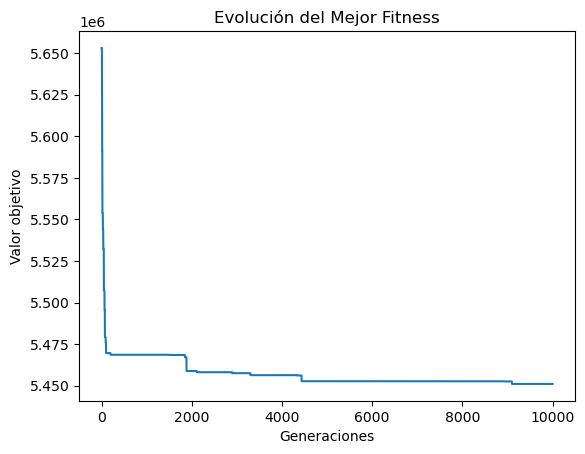

True

In [111]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### One Point Method

Solución conocida:  5426670
La solución: [14 10  0  7  3 22  1 13  5 11 19 20  4  8 25 17  6  2 18 24 15 16 23  9
 21 12]
El fitness de la mejor solución: 5452655
Tiempo de ejecución: 193.20294976234436 segundos


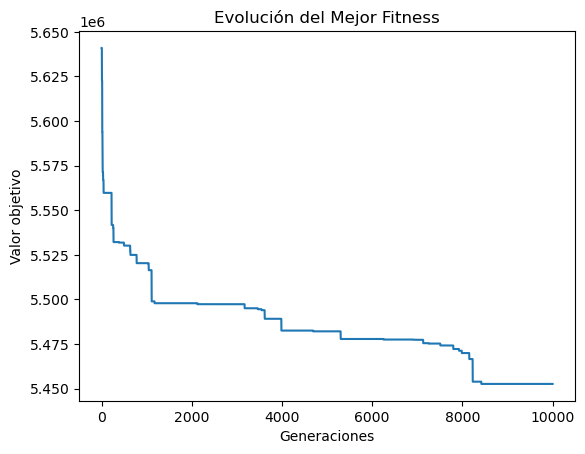

True

In [113]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  5426670
La solución: [11  1 19  5 17  7  6 14 20 15  2  3 13  8  9 10 18  4  0 22 12 21 23 16
 25 24]
El fitness de la mejor solución: 5498443
Tiempo de ejecución: 200.00945377349854 segundos


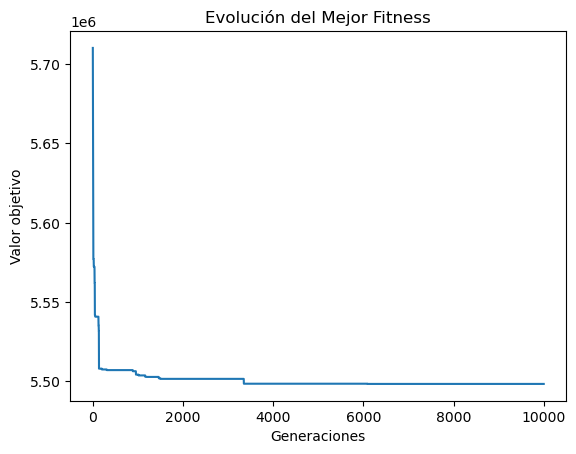

True

In [114]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  5426670
La solución: [22 13  1 10 11 24 16 14 23 20 19 17  7  6  5  3 18  8  4  2  9 21 12 15
 25  0]
El fitness de la mejor solución: 5449414
Tiempo de ejecución: 245.5474669933319 segundos


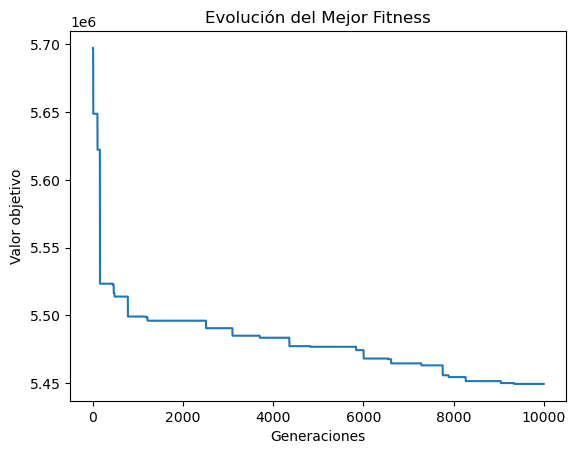

True

In [115]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5426670)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 2: bur26b.dat (3817852)

In [117]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./bur26b.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  3817852
La solución: [11  0 10 23 13 21  8  1 16 24 18 19 20  3  4 15  9  5 14 12 22  2  7  6
 17 25]
El fitness de la mejor solución: 3836826
Tiempo de ejecución: 230.74625372886658 segundos


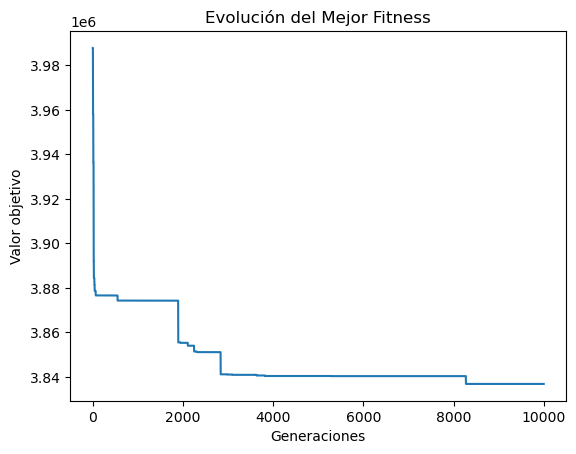

True

In [118]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  3817852
La solución: [25 21 15  7  4 13 14  2  6 11  8  9  5  3 16 12 18 20 19  0 17  1 24 10
 23 22]
El fitness de la mejor solución: 3846556
Tiempo de ejecución: 224.04447293281555 segundos


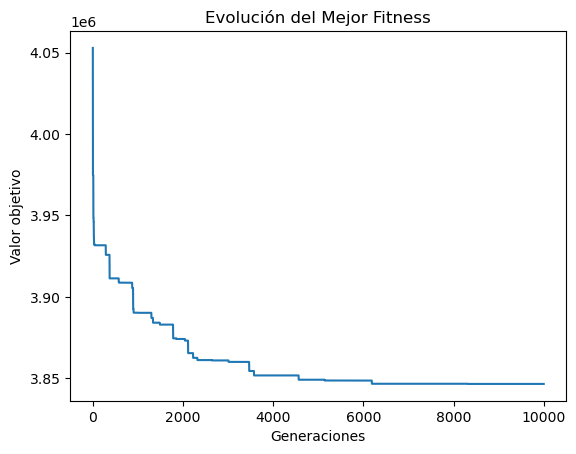

True

In [119]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  3817852
La solución: [24  8 17  6  2  4 25 16 15  7 14 19  9 12 23 10 21  5  1 18 22 11  0 13
  3 20]
El fitness de la mejor solución: 3842977
Tiempo de ejecución: 222.89882397651672 segundos


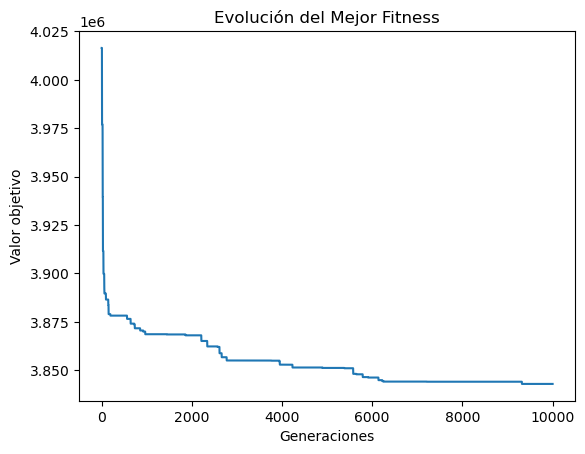

True

In [120]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  3817852
La solución: [ 3  4 21 25 11 17 24  6  0 15  9 20  5 12 23 19 14  1 18  7 22 16 10  2
  8 13]
El fitness de la mejor solución: 3868551
Tiempo de ejecución: 277.7765338420868 segundos


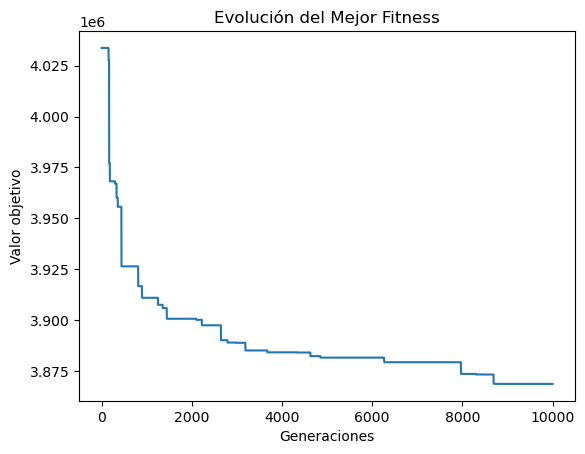

True

In [121]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 3817852)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos) 

### Ciclo 3: bur26e.dat (5386879)

In [128]:
nInstalaciones,matrizF,matrizD  = leerArchivo('./bur26e.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  5386879
La solución: [ 2  7 17  4 16  3 12 10 13 21 15  1  5 20 22 18 14  9 19 23 24  0  8  6
 25 11]
El fitness de la mejor solución: 5442567
Tiempo de ejecución: 245.183758020401 segundos


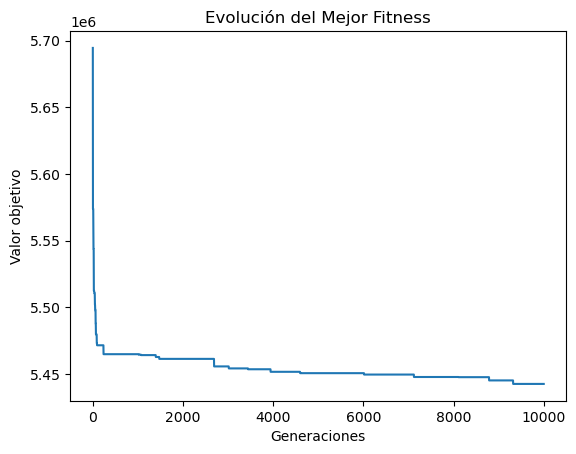

True

In [130]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


Solución conocida:  5386879
La solución: [13 14 22  7  3 24 11 25  1  4 20 18 21 19 12  2 15  9  5 17 10  0  6 16
  8 23]
El fitness de la mejor solución: 5415986
Tiempo de ejecución: 221.62790393829346 segundos


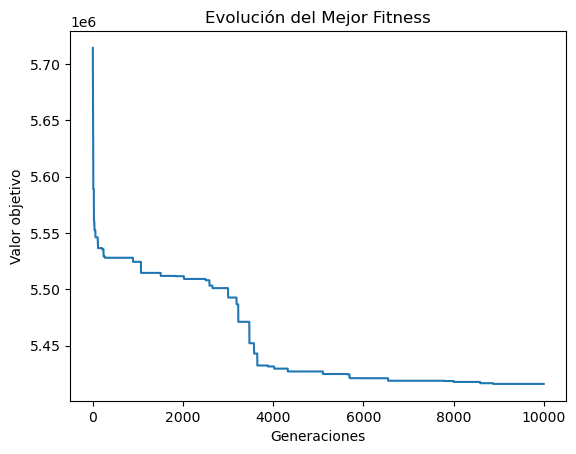

True

In [132]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

Solución conocida:  5386879
La solución: [15 10 17 24  2 16 13 14 21 20  1  9  5 19  4  7 12 18  3 23 25 11  0  8
  6 22]
El fitness de la mejor solución: 5472012
Tiempo de ejecución: 224.38997888565063 segundos


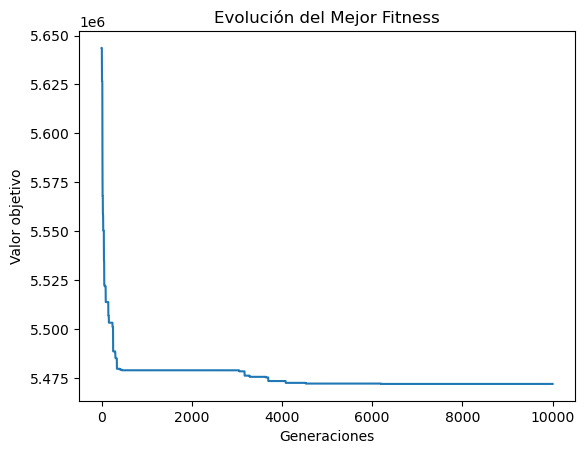

True

In [133]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

Solución conocida:  5386879
La solución: [21  3 25 13 18 15  2 11  4 16 12 14  9 19  8  7  1  5 20  6 22 10 23  0
 17 24]
El fitness de la mejor solución: 5461599
Tiempo de ejecución: 288.94416093826294 segundos


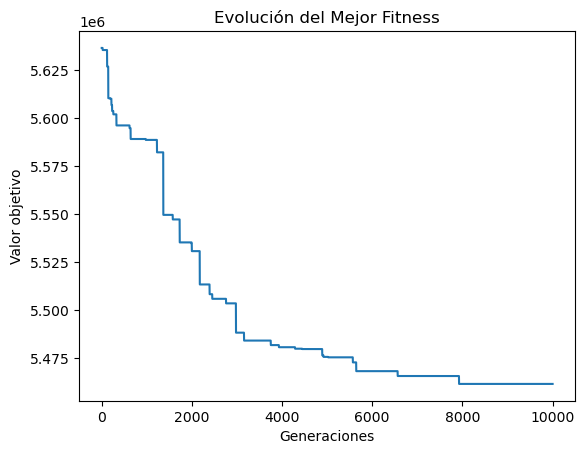

True

In [134]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 5386879)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 4: chr12a.dat (9552)

In [140]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./chr12a.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

Solución conocida:  9552
La solución: [ 6 11  9  0  4  8  2  7 10  5  1  3]
El fitness de la mejor solución: 11646
Tiempo de ejecución: 54.1260449886322 segundos


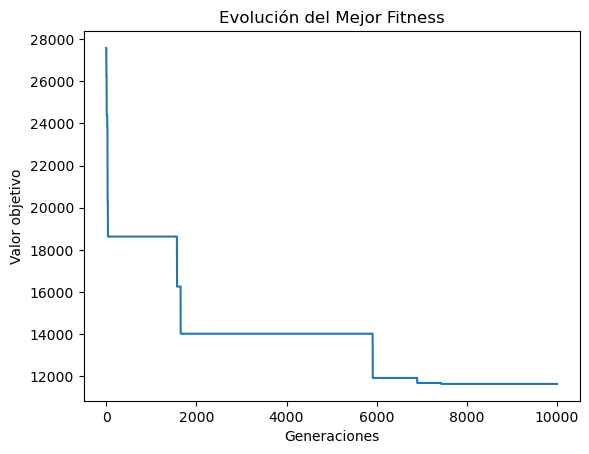

True

In [142]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


In [143]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

La solución: [ 7  5  4  2  1  3  9  6 10 11  8  0]
El fitness de la mejor solución: 5096
Tiempo de ejecución: 32.19564700126648 segundos


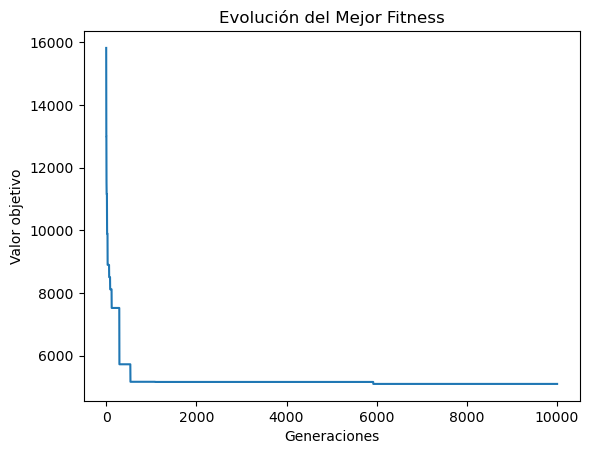

True

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9552)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 5: chr15c.dat (9504)

In [71]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./chr15c.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 9504)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

### Ciclo 6: chr18a.dat (11098)

In [72]:
nInstalaciones,matrizF,matrizD, = leerArchivo('./chr18a.dat')
matrizD2 = np.array(matrizD)
matrizF2 = np.array(matrizF)
instanciaQAP = QAP(matrizD2, matrizF2)

#### Uniform

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "uniform", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### OnePoint Method


In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Two Point Method

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "twopoint", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)

#### Heuristic Method

In [ ]:
start_time = time.time()
mejorSoluciones, mejoresCostos = GA(instanciaQAP, 50, 0.001, 10000, "heuristic", elite_ratio=0.1)
end_time = time.time()
execution_time = end_time - start_time
print("Solución conocida: ", 11098)
print("La solución:", mejorSoluciones)
print("El fitness de la mejor solución:", min(mejoresCostos))
print("Tiempo de ejecución:", execution_time, "segundos")
graficar(mejoresCostos)